In [1]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ankushsirsathe","key":"afe41e039afa5a57bde601d22ab027b6"}'}

In [2]:
# === Setup Kaggle credentials ===
import os
import zipfile

os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# === Download the Uber Pickups Dataset ===
!kaggle datasets download -d fivethirtyeight/uber-pickups-in-new-york-city

# === Unzip the downloaded file ===
!unzip uber-pickups-in-new-york-city.zip -d uber_data


Dataset URL: https://www.kaggle.com/datasets/fivethirtyeight/uber-pickups-in-new-york-city
License(s): CC0-1.0
uber-pickups-in-new-york-city.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  uber-pickups-in-new-york-city.zip
replace uber_data/Uber-Jan-Feb-FOIL.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uber_data/Uber-Jan-Feb-FOIL.csv  
replace uber_data/other-American_B01362.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uber_data/other-American_B01362.csv  
replace uber_data/other-Carmel_B00256.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uber_data/other-Carmel_B00256.csv  
replace uber_data/other-Dial7_B00887.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uber_data/other-Dial7_B00887.csv  
replace uber_data/other-Diplo_B01196.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uber_data/other-Diplo_B01196.csv  
replace uber_data/other-FHV-services_jan-aug-2015.csv? [y]es, [n]o, [A]l

In [4]:
import pandas as pd
import glob

# === Load all CSVs from the extracted folder ===
all_files = glob.glob("uber_data/uber-raw-data-*.csv")

# Load and combine them
dfs = []
for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

uber_df = pd.concat(dfs, ignore_index=True)
uber_df.head()


,Date/Time,Lat,Lon,Base,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,5/1/2014 0:02:00,40.7521,-73.9914,B02512,NaN,NaN,NaN,NaN
1,5/1/2014 0:06:00,40.6965,-73.9715,B02512,NaN,NaN,NaN,NaN
2,5/1/2014 0:15:00,40.7464,-73.9838,B02512,NaN,NaN,NaN,NaN
3,5/1/2014 0:17:00,40.7463,-74.0011,B02512,NaN,NaN,NaN,NaN
4,5/1/2014 0:17:00,40.7594,-73.9734,B02512,NaN,NaN,NaN,NaN


In [5]:
# Convert 'Date/Time' to datetime format
uber_df['Date/Time'] = pd.to_datetime(uber_df['Date/Time'], errors='coerce')

# Extract key time-based features
uber_df['Hour'] = uber_df['Date/Time'].dt.hour
uber_df['Day'] = uber_df['Date/Time'].dt.day
uber_df['Weekday'] = uber_df['Date/Time'].dt.day_name()
uber_df['Month'] = uber_df['Date/Time'].dt.month
uber_df['Date'] = uber_df['Date/Time'].dt.date

# Preview the updated data
uber_df[['Date/Time', 'Hour', 'Day', 'Weekday', 'Month']].head()


,Date/Time,Hour,Day,Weekday,Month
0,2014-05-01 00:02:00,0.0,1.0,Thursday,5.0
1,2014-05-01 00:06:00,0.0,1.0,Thursday,5.0
2,2014-05-01 00:15:00,0.0,1.0,Thursday,5.0
3,2014-05-01 00:17:00,0.0,1.0,Thursday,5.0
4,2014-05-01 00:17:00,0.0,1.0,Thursday,5.0


/tmp/ipython-input-6-3878055566.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


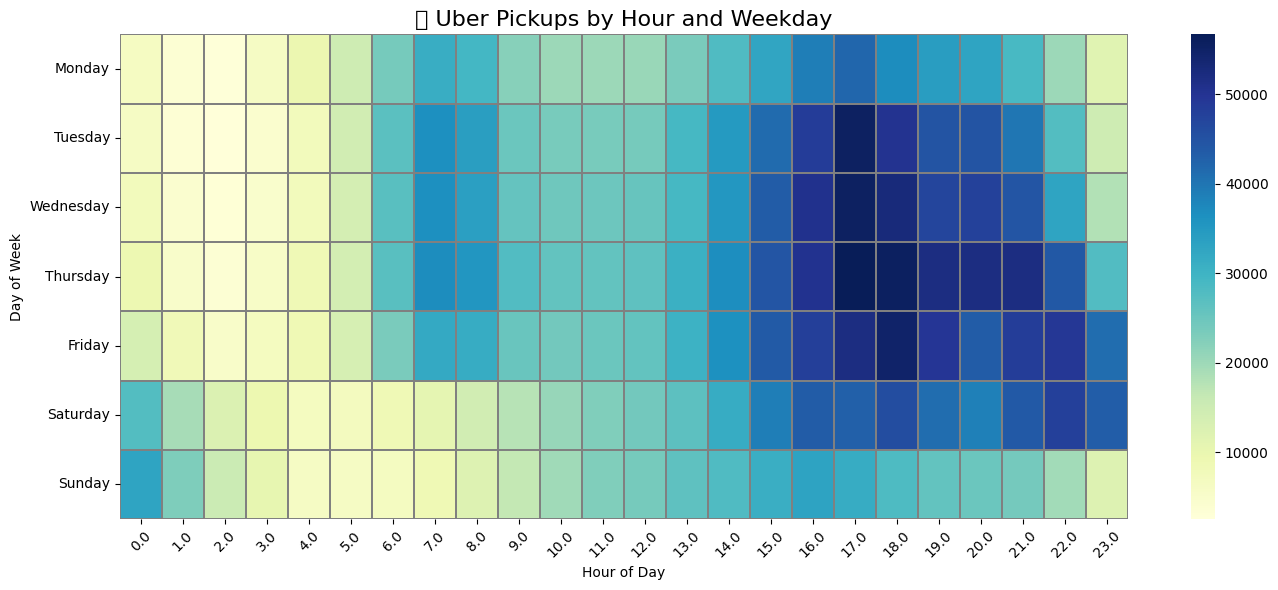

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: Group by Weekday and Hour
heatmap_data = uber_df.groupby(['Weekday', 'Hour']).size().unstack()

# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.3, linecolor='gray')
plt.title('📊 Uber Pickups by Hour and Weekday', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [7]:
import plotly.express as px

# Group by date
daily_rides = uber_df.groupby('Date').size().reset_index(name='Total Rides')

# Interactive line chart
fig = px.line(daily_rides, x='Date', y='Total Rides',
              title='📅 Daily Uber Pickups in NYC',
              labels={'Total Rides': 'Number of Rides'},
              template='plotly_dark')

fig.update_traces(mode='lines+markers')
fig.update_layout(title_font_size=20, hovermode='x unified')
fig.show()


In [8]:
import pandas as pd
import plotly.graph_objects as go
import glob

# Step 1: Read Data
all_files = glob.glob("uber_data/uber-raw-data-*.csv")
dfs = [pd.read_csv(file) for file in all_files]
uber_df = pd.concat(dfs, ignore_index=True)

# Step 2: Preprocess
uber_df['Date/Time'] = pd.to_datetime(uber_df['Date/Time'])
uber_df['Date'] = uber_df['Date/Time'].dt.date
daily = uber_df.groupby('Date').size().reset_index(name='Daily Rides')
daily['Date'] = pd.to_datetime(daily['Date'])
daily = daily.sort_values('Date').reset_index(drop=True)
daily['Cumulative Rides'] = daily['Daily Rides'].cumsum()
daily['Date_str'] = daily['Date'].dt.strftime('%Y-%m-%d')

# Step 3: Build Frames
frames = []
for i in range(2, len(daily) + 1):
    frames.append(go.Frame(
        data=[go.Scatter(
            x=daily['Date'][:i],
            y=daily['Cumulative Rides'][:i],
            fill='tozeroy',
            mode='lines+markers',
            line=dict(color='limegreen', width=4),
            marker=dict(size=4)
        )],
        name=daily['Date_str'][i-1]
    ))

# Step 4: Animated Figure
fig = go.Figure(
    data=[go.Scatter(
        x=[daily['Date'][0]],
        y=[daily['Cumulative Rides'][0]],
        fill='tozeroy',
        mode='lines+markers',
        line=dict(color='limegreen', width=4),
        marker=dict(size=4)
    )],
    layout=go.Layout(
        title='📈 Cumulative Uber Pickups in NYC (Apr–Sep 2014)',
        title_font_size=22,
        xaxis=dict(title='Date', range=[daily['Date'].min(), daily['Date'].max()]),
        yaxis=dict(title='Total Cumulative Pickups', range=[0, daily['Cumulative Rides'].max() + 1000]),
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        showlegend=False,
        updatemenus=[dict(
            type='buttons',
            buttons=[
                dict(label='▶ Play', method='animate', args=[None, {
                    'frame': {'duration': 40, 'redraw': True},
                    'fromcurrent': True
                }]),
                dict(label='⏸ Pause', method='animate', args=[[None], {
                    'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'
                }])
            ],
            x=0.1, y=-0.2, showactive=True
        )],
        sliders=[dict(
            steps=[dict(method='animate', args=[[frame.name], {"mode": "immediate"}], label=frame.name)
                   for frame in frames],
            transition=dict(duration=0),
            x=0.1, y=-0.1, currentvalue=dict(prefix="📅 ", font=dict(color='white'))
        )]
    ),
    frames=frames
)

fig.show()


In [9]:
# Install folium & branca if not installed
!pip install folium branca --quiet
import pandas as pd
import folium
from folium.plugins import HeatMap


In [10]:
from folium.plugins import HeatMapWithTime
import numpy as np

# Add 'hour' column
uber_df['Hour'] = uber_df['Date/Time'].dt.hour

# Focus on a single month to keep it fast
month_df = uber_df[uber_df['Date/Time'].dt.month == 7]  # July
month_df = month_df[['Lat', 'Lon', 'Hour']].dropna()

# Group by hour for animation
hourly_data = []
for hour in range(24):
    hour_group = month_df[month_df['Hour'] == hour]
    points = hour_group[['Lat', 'Lon']].values.tolist()
    hourly_data.append(points)

# NYC center
nyc_center = [40.7128, -74.0060]

# Create time heatmap
m = folium.Map(location=nyc_center, zoom_start=11, tiles='CartoDB positron')
HeatMapWithTime(hourly_data,
                index=[f"{h}:00" for h in range(24)],
                auto_play=True,
                radius=7).add_to(m)

m


Output hidden; open in https://colab.research.google.com to view.

In [11]:
import pandas as pd
import numpy as np

# --- KPI Calculations ---
total_rides = len(uber_df)

# Peak day
daily_counts = uber_df.groupby(uber_df['Date/Time'].dt.date).size()
peak_day = daily_counts.idxmax()
peak_day_count = daily_counts.max()

# Peak hour
uber_df['Hour'] = uber_df['Date/Time'].dt.hour
peak_hour = uber_df['Hour'].value_counts().idxmax()

# Most active location center
lat_center = round(uber_df['Lat'].mean(), 4)
lon_center = round(uber_df['Lon'].mean(), 4)

# Display KPIs
print("📊 UBER NYC RIDE INSIGHTS (Apr–Sep 2014)")
print("-" * 50)
print(f"🚗 Total Pickups        : {total_rides:,}")
print(f"📆 Peak Day             : {peak_day} ({peak_day_count:,} rides)")
print(f"⏰ Most Active Hour     : {peak_hour}:00")
print(f"📍 Activity Center      : Lat {lat_center}, Lon {lon_center}")


📊 UBER NYC RIDE INSIGHTS (Apr–Sep 2014)
--------------------------------------------------
🚗 Total Pickups        : 18,804,806
📆 Peak Day             : 2014-09-13 (43,205 rides)
⏰ Most Active Hour     : 17.0:00
📍 Activity Center      : Lat 40.7393, Lon -73.973


In [12]:
# Prepare daily counts
daily_counts = uber_df.groupby(uber_df['Date/Time'].dt.date).size().reset_index(name='Total Rides')
daily_counts.columns = ['Date', 'Total Rides']
daily_counts['Date'] = pd.to_datetime(daily_counts['Date'])

# Find peak
peak_row = daily_counts.loc[daily_counts['Total Rides'].idxmax()]

# Plot
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=daily_counts['Date'],
    y=daily_counts['Total Rides'],
    mode='lines+markers',
    name='Daily Rides',
    line=dict(color='deepskyblue', width=3),
    marker=dict(size=4)
))

# Highlight peak point
fig.add_trace(go.Scatter(
    x=[peak_row['Date']],
    y=[peak_row['Total Rides']],
    mode='markers+text',
    name='Peak Day',
    marker=dict(color='red', size=10),
    text=[f"🔥 Peak: {peak_row['Total Rides']}"],
    textposition="top center"
))

fig.update_layout(
    title='📈 Uber Daily Ride Volume (Apr–Sep 2014)',
    xaxis_title='Date',
    yaxis_title='Number of Rides',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


In [13]:
# Install Prophet
!pip install prophet --quiet

# Imports
from prophet import Prophet
import pandas as pd


In [17]:
import os
os.listdir('/content')


['.config',
 'uber-pickups-in-new-york-city.zip',
 'kaggle (1).json',
 'heatmap_weekday_hour.png',
 'uber_data',
 'heatmap.html',
 'kaggle.json',
 'uber_pickup_heatmap.html',
 'pickup_heatmap.html',
 'iframe_figures',
 'uber_data.csv',
 'filtered_uber_data.csv',
 'sample_data']

In [18]:
import zipfile
import os
from glob import glob
import pandas as pd

# Step 1: Unzip the dataset
zip_path = "uber-pickups-in-new-york-city.zip"
unzip_dir = "/content/uber_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Step 2: Read and merge the CSVs inside
csv_files = glob(f"{unzip_dir}/*.csv")
df_list = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        if 'Date/Time' in df.columns:
            df = df[['Date/Time', 'Lat', 'Lon']]
        elif 'pickup_datetime' in df.columns:
            df = df.rename(columns={'pickup_datetime': 'Date/Time'})[['Date/Time', 'Lat', 'Lon']]
        else:
            print(f"⚠️ Skipping {file}: Date/Time column not found.")
            continue
        df_list.append(df.dropna())
    except Exception as e:
        print(f"❌ Error in {file}: {e}")

# Step 3: Merge and save
uber_df = pd.concat(df_list, ignore_index=True)
uber_df.to_csv("uber_data.csv", index=False)
print(f"✅ Merged {len(df_list)} files into 'uber_data.csv' with {len(uber_df):,} rows.")


⚠️ Skipping /content/uber_data/other-American_B01362.csv: Date/Time column not found.
❌ Error in /content/uber_data/other-Highclass_B01717.csv: 'utf-8' codec can't decode byte 0xf1 in position 94051: invalid continuation byte
⚠️ Skipping /content/uber_data/other-Lyft_B02510.csv: Date/Time column not found.
❌ Error in /content/uber_data/other-Carmel_B00256.csv: 'utf-8' codec can't decode byte 0x96 in position 56424: invalid start byte
❌ Error in /content/uber_data/other-Firstclass_B01536.csv: 'utf-8' codec can't decode byte 0xa4 in position 82554: invalid start byte
⚠️ Skipping /content/uber_data/uber-raw-data-janjune-15.csv: Date/Time column not found.
⚠️ Skipping /content/uber_data/other-Dial7_B00887.csv: Date/Time column not found.
⚠️ Skipping /content/uber_data/other-Skyline_B00111.csv: Date/Time column not found.
❌ Error in /content/uber_data/other-Prestige_B01338.csv: 'utf-8' codec can't decode byte 0xae in position 115594: invalid start byte
⚠️ Skipping /content/uber_data/other-F

In [19]:
import pandas as pd
import numpy as np

# Load the full dataset
uber_df = pd.read_csv("uber_data.csv")
uber_df['Date/Time'] = pd.to_datetime(uber_df['Date/Time'])

# Feature engineering
uber_df['Date'] = uber_df['Date/Time'].dt.date
uber_df['Day'] = uber_df['Date/Time'].dt.day_name()
uber_df['Hour'] = uber_df['Date/Time'].dt.hour
uber_df['Week'] = uber_df['Date/Time'].dt.isocalendar().week
uber_df['Month'] = uber_df['Date/Time'].dt.month_name()
uber_df['Year'] = uber_df['Date/Time'].dt.year
uber_df['DayOfMonth'] = uber_df['Date/Time'].dt.day
uber_df['Minute'] = uber_df['Date/Time'].dt.minute

# Check shape and preview
print(f"✅ Data loaded: {uber_df.shape[0]:,} rows")
uber_df.head()


✅ Data loaded: 4,534,327 rows


,Date/Time,Lat,Lon,Date,Day,Hour,Week,Month,Year,DayOfMonth,Minute
0,2014-05-01 00:02:00,40.7521,-73.9914,2014-05-01,Thursday,0,18,May,2014,1,2
1,2014-05-01 00:06:00,40.6965,-73.9715,2014-05-01,Thursday,0,18,May,2014,1,6
2,2014-05-01 00:15:00,40.7464,-73.9838,2014-05-01,Thursday,0,18,May,2014,1,15
3,2014-05-01 00:17:00,40.7463,-74.0011,2014-05-01,Thursday,0,18,May,2014,1,17
4,2014-05-01 00:17:00,40.7594,-73.9734,2014-05-01,Thursday,0,18,May,2014,1,17


In [20]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Create widgets
date_range = widgets.SelectionRangeSlider(
    options=sorted(uber_df['Date'].unique()),
    index=(0, len(uber_df['Date'].unique()) - 1),
    description='📅 Date',
    orientation='horizontal',
    layout={'width': '90%'}
)

hour_range = widgets.IntRangeSlider(
    value=[0, 23],
    min=0,
    max=23,
    step=1,
    description='🕓 Hour',
    layout={'width': '90%'}
)

display(Markdown("### 🔍 Select Date and Hour Range"))
display(date_range, hour_range)


### 🔍 Select Date and Hour Range

SelectionRangeSlider(description='📅 Date', index=(0, 182), layout=Layout(width='90%'), options=(datetime.date(…

IntRangeSlider(value=(0, 23), description='🕓 Hour', layout=Layout(width='90%'), max=23)

In [21]:
from IPython.display import HTML, display
import uuid
import folium

def display_folium_map(m, width=950, height=500):
    map_id = "folium_" + str(uuid.uuid4())
    html = m.get_root().render()
    iframe = f"""
    <iframe srcdoc='{html.replace("'", "&apos;")}' width="{width}" height="{height}" frameborder="0"></iframe>
    """
    display(HTML(iframe))


In [25]:
!pip install --quiet prophet


In [26]:
from prophet import Prophet


In [32]:
# Ensure correct format
uber_df['Date'] = pd.to_datetime(uber_df['Date'])
uber_df['Hour'] = uber_df['Date/Time'].dt.hour
uber_df['Day'] = uber_df['Date/Time'].dt.strftime('%A')

# Example filters (change to your preferred range)
start_date = '2014-04-01'
end_date = '2014-09-30'
min_hour = 6
max_hour = 22

# Filter the dataset
filtered_df = uber_df[
    (uber_df['Date'] >= pd.to_datetime(start_date)) &
    (uber_df['Date'] <= pd.to_datetime(end_date)) &
    (uber_df['Hour'] >= min_hour) &
    (uber_df['Hour'] <= max_hour)
]

print(f"✅ Filtered data has {len(filtered_df):,} rows between {start_date} and {end_date}, from {min_hour}:00 to {max_hour}:00.")


✅ Filtered data has 3,960,753 rows between 2014-04-01 and 2014-09-30, from 6:00 to 22:00.


In [34]:
# Example setup for filtering
start_date = '2014-04-01'
end_date = '2014-09-30'
min_hour = 6
max_hour = 22

# Ensure Date and Hour are ready
uber_df['Date'] = pd.to_datetime(uber_df['Date'])
uber_df['Hour'] = uber_df['Date/Time'].dt.hour
uber_df['Day'] = uber_df['Date/Time'].dt.strftime('%A')

# Create filtered dataset
filtered_df = uber_df[
    (uber_df['Date'] >= pd.to_datetime(start_date)) &
    (uber_df['Date'] <= pd.to_datetime(end_date)) &
    (uber_df['Hour'] >= min_hour) &
    (uber_df['Hour'] <= max_hour)
]


In [35]:
filtered_df['Hour'] = filtered_df['Date/Time'].dt.hour
filtered_df['Day'] = filtered_df['Date/Time'].dt.strftime('%A')


/tmp/ipython-input-35-3741352801.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-35-3741352801.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipython-input-36-400691076.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-36-400691076.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-36-400691076.py:24: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.



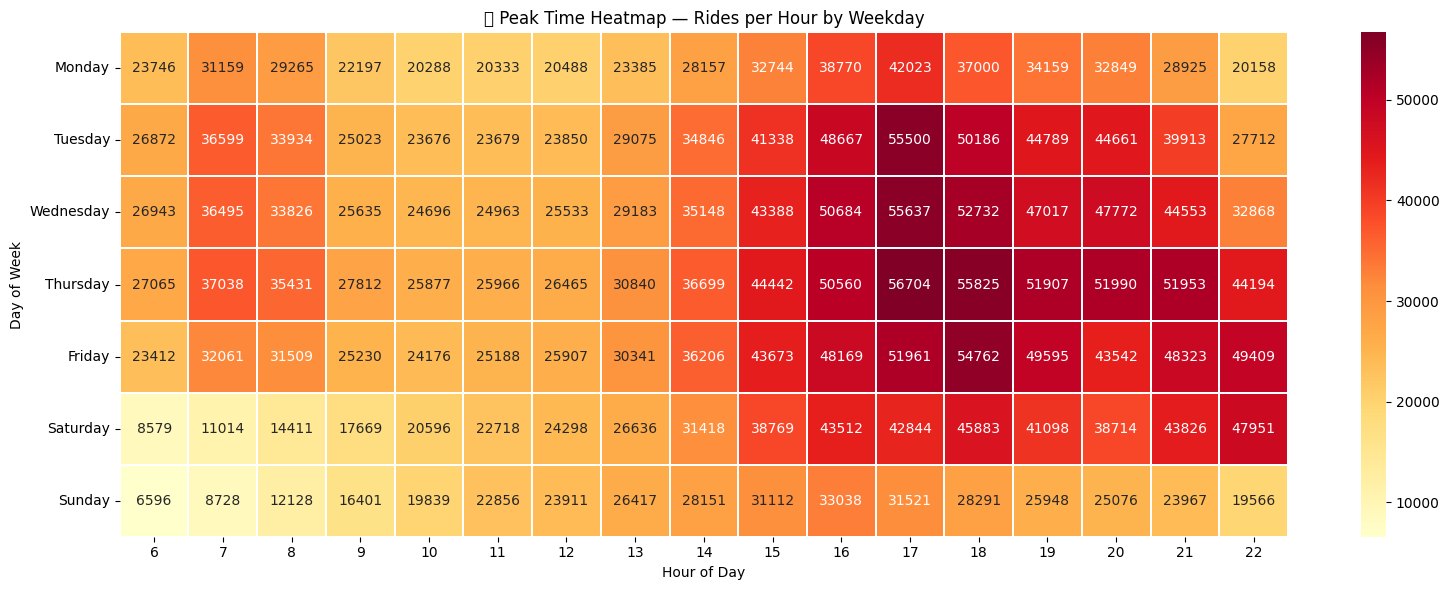

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make sure the necessary columns exist
filtered_df['Hour'] = filtered_df['Date/Time'].dt.hour
filtered_df['Day'] = filtered_df['Date/Time'].dt.strftime('%A')

# Step 2: Group by Day & Hour
hourly = filtered_df.groupby(['Day', 'Hour']).size().reset_index(name='Pickups')

# Step 3: Order weekdays correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly['Day'] = pd.Categorical(hourly['Day'], categories=day_order, ordered=True)

# Step 4: Create pivot table
pivot_table = hourly.pivot(index='Day', columns='Hour', values='Pickups').fillna(0)

# Step 5: Plot heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', linewidths=0.3, annot=True, fmt='.0f')
plt.title("🔥 Peak Time Heatmap — Rides per Hour by Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()
